In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

Process data

In [21]:
# Path to experiment folder
experiment_folder = "../data/experiment-i"
subject_folders = sorted(glob.glob(os.path.join(experiment_folder, "S*")))
# Dictionary to store data: {subject: {posture: frames}}
subject_posture_data = {}

for subject in subject_folders:
    subject_id = os.path.basename(subject)  # e.g., "S1"
    subject_posture_data[subject_id] = {}  # Initialize subject dictionary

    # Find all posture .txt files (e.g., "1.txt", "2.txt", etc.)
    txt_files = sorted(glob.glob(os.path.join(subject, "*.txt")))

    for txt_file in txt_files:
        posture_id = os.path.splitext(os.path.basename(txt_file))[0]  # Extract posture name (e.g., "1", "2")

        # Manually read and clean the file
        cleaned_data = []
        with open(txt_file, "r") as f:
            for line in f:
                line = line.strip()
                if line and not any(c.isalpha() for c in line):  # Ignore empty lines and non-numeric separators
                    cleaned_data.append([float(x) for x in line.split("\t")])  # Convert valid numeric data

        # Convert to NumPy array
        data = np.array(cleaned_data)

        # **Convert raw values (0-1000) to mmHg (0-100)**
        data = data * 0.1  # Apply conversion factor

        # Compute the number of frames
        total_values = data.size
        num_frames = total_values // (32 * 64)

        frames = data[: num_frames * 64 * 32].reshape(num_frames, 64, 32)
        frames = frames[2:]  # Only start at frame 3

        # Store frames under subject -> posture
        subject_posture_data[subject_id][posture_id] = frames


Only keep number starting at frame 3 because frame 1 and 2 include values way over 1000, which is past the range that sensor records.

In [22]:
subject_posture_data.keys()

dict_keys(['S1', 'S10', 'S11', 'S12', 'S13', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9'])

In [23]:
# Print the structure of loaded data
for subject, postures in subject_posture_data.items():
    print(f"{subject}:")
    for posture, frames in postures.items():
        print(f"  Posture {posture}: {frames.shape[0]} frames")

S1:
  Posture 1: 80 frames
  Posture 10: 71 frames
  Posture 11: 78 frames
  Posture 12: 73 frames
  Posture 13: 79 frames
  Posture 14: 74 frames
  Posture 15: 91 frames
  Posture 16: 79 frames
  Posture 17: 88 frames
  Posture 2: 68 frames
  Posture 3: 88 frames
  Posture 4: 67 frames
  Posture 5: 76 frames
  Posture 6: 67 frames
  Posture 7: 67 frames
  Posture 8: 70 frames
  Posture 9: 72 frames
S10:
  Posture 1: 80 frames
  Posture 10: 70 frames
  Posture 11: 68 frames
  Posture 12: 77 frames
  Posture 13: 74 frames
  Posture 14: 77 frames
  Posture 15: 73 frames
  Posture 16: 82 frames
  Posture 17: 79 frames
  Posture 2: 66 frames
  Posture 3: 77 frames
  Posture 4: 76 frames
  Posture 5: 70 frames
  Posture 6: 86 frames
  Posture 7: 70 frames
  Posture 8: 73 frames
  Posture 9: 105 frames
S11:
  Posture 1: 92 frames
  Posture 10: 69 frames
  Posture 11: 66 frames
  Posture 12: 66 frames
  Posture 13: 73 frames
  Posture 14: 65 frames
  Posture 15: 75 frames
  Posture 16: 66 fra

In [24]:
subject_posture_data["S1"]["1"][0][0].shape

(32,)

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pose_comparison(pose1_id, pose2_id, levels=15):
    """
    Plots a side-by-side contour map comparing the average pressure distribution 
    of two postures with identical contour levels.

    Parameters:
        pose1_id (str): Posture identifier for the first pose 
        pose2_id (str): Posture identifier for the second pose 
        levels (int): Number of contour levels (default is 15)
    """
    
    all_frames_pose1, all_frames_pose2 = [], []

    # Collect frames for Pose 1
    for subject, postures in subject_posture_data.items():
        if pose1_id in postures:
            # print(postures[pose1_id])
            all_frames_pose1.append(postures[pose1_id])  # Shape: (num_frames, 32, 64)

    print(all_frames_pose1)

    # Collect frames for Pose 2
    for subject, postures in subject_posture_data.items():
        if pose2_id in postures :
            all_frames_pose2.append(postures[pose2_id])  # Shape: (num_frames, 32, 64)

    if all_frames_pose1 and all_frames_pose2:
        # Find minimum frame count across subjects for both postures
        min_frames_pose1 = min(f.shape[0] for f in all_frames_pose1)
        min_frames_pose2 = min(f.shape[0] for f in all_frames_pose2)

        # Trim all subject data to have the same frame count
        trimmed_pose1 = [f[:min_frames_pose1] for f in all_frames_pose1]
        trimmed_pose2 = [f[:min_frames_pose2] for f in all_frames_pose2]

        # Compute average pressure map for each posture
        avg_pose1 = np.mean(np.array(trimmed_pose1), axis=(0, 1))  # Mean over subjects and frames
        avg_pose2 = np.mean(np.array(trimmed_pose2), axis=(0, 1))  # Mean over subjects and frames

        # Find global min/max for consistent color scale
        vmin = min(avg_pose1.min(), avg_pose2.min())
        vmax = max(avg_pose1.max(), avg_pose2.max())

        # Generate identical contour levels
        contour_levels = np.linspace(vmin, vmax, levels)

        # Generate side-by-side contour plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 12))

        # Contour Plot for Pose 1
        X, Y = np.meshgrid(np.arange(avg_pose1.shape[1]), np.arange(avg_pose1.shape[0]))
        contour1 = axes[0].contourf(X, Y, avg_pose1, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        axes[0].set_title('Sleeping on the Back')
        axes[0].set_xlabel('Width')
        axes[0].set_ylabel('Height')
        axes[0].invert_yaxis()
        axes[0].tick_params(colors='white')

        # Contour Plot for Pose 2
        contour2 = axes[1].contourf(X, Y, avg_pose2, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        axes[1].set_title(f'Sleeping on the Left')
        axes[1].set_xlabel('Width')
        axes[1].invert_yaxis()
        axes[1].tick_params(colors='white')

        # Common colorbar for both plots with white font
        cbar = fig.colorbar(contour2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label('Pressure', color='white')
        cbar.ax.yaxis.set_tick_params(color='white')  # Change tick color
        plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')  # Change tick label color

        # Set white text for the entire figure
        
        plt.suptitle(f'Pressure Comparison: Posture {pose1_id} vs. Posture {pose2_id} (Same Contour Levels)', color='white')
        plt.tight_layout()
        plt.show()

    else:
        print(f"Not enough data found for Posture {pose1_id} or Posture {pose2_id}.")

[array([[[0. , 0. , 0. , ..., 0.2, 0. , 0. ],
        [0.1, 0.3, 0. , ..., 0.1, 0. , 0. ],
        [0.1, 0.3, 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0.1, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.1, 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0. , 0. , 0. , ..., 0.2, 0. , 0. ],
        [0.1, 0.2, 0. , ..., 0.1, 0. , 0. ],
        [0.1, 0.3, 0.1, ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0.1, 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0. , 0.1, 0. , ..., 0.3, 0. , 0. ],
        [0.1, 0.2, 0. , ..., 0. , 0. , 0. ],
        [0. , 0.2, 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       ...,

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0.1, 0. , ..., 0. , 0. , 0. ],
        [0.2, 0.2, 0.1, ..., 0. , 0. , 0.

C:\Users\lincc\AppData\Local\Temp\ipykernel_36516\261430250.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


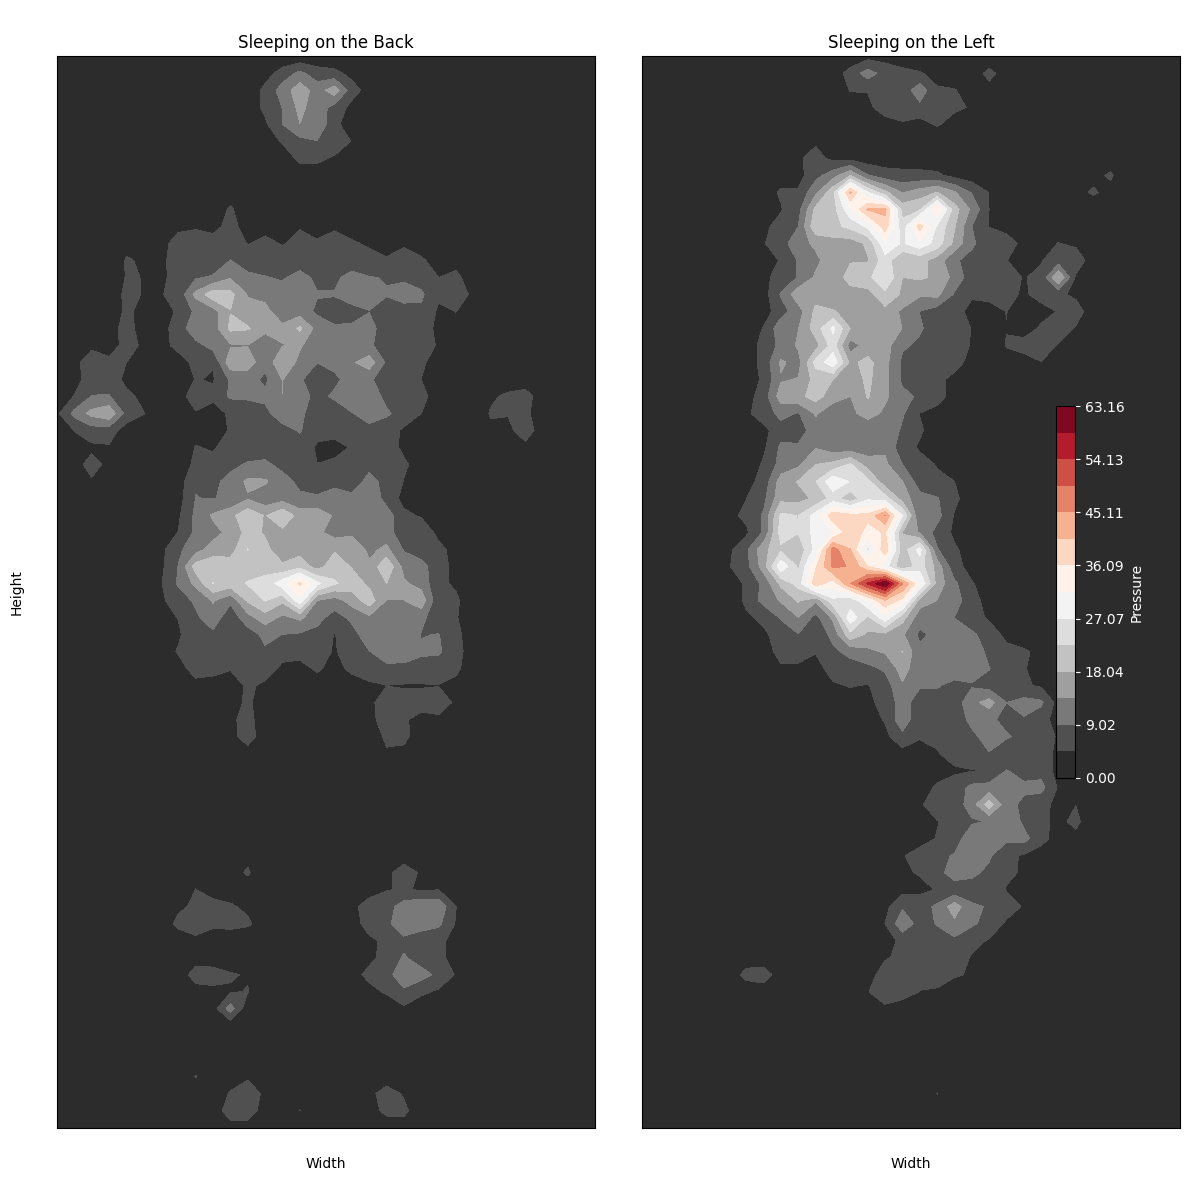

In [26]:
plot_pose_comparison(pose1_id="1", pose2_id="2")


In [27]:
info = pd.read_csv(r'../data/subject_info.csv')
info.head()

,Subject-Number,Age,Height/cm,Weight/kg
0,1,19,175,87
1,2,23,183,85
2,3,23,183,100
3,4,24,177,70
4,5,24,172,66


In [28]:
info["Height/cm"].values[0]

np.int64(175)

In [30]:
info['BMI'] =  info['Weight/kg'] / ((info['Height/cm'] / 100)**2)

def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal weight"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obesity"

# Apply the function to the BMI column
info['BMI Category'] = info['BMI'].apply(categorize_bmi)

In [31]:
info['Subject-Number'] = info['Subject-Number'].apply(lambda a: 'S' + str(a))
info

,Subject-Number,Age,Height/cm,Weight/kg,BMI,BMI Category
0,S1,19,175,87,28.408163,Overweight
1,S2,23,183,85,25.381469,Overweight
2,S3,23,183,100,29.860551,Overweight
3,S4,24,177,70,22.343516,Normal weight
4,S5,24,172,66,22.309356,Normal weight
5,S6,26,169,83,29.060607,Overweight
6,S7,27,179,96,29.961612,Overweight
7,S8,27,186,63,18.210198,Underweight
8,S9,30,174,74,24.441802,Normal weight
9,S10,30,174,79,26.093275,Overweight


In [32]:
overweight_subject = info[info['BMI Category'] == 'Overweight']['Subject-Number'].values
overweight_subject

array(['S1', 'S2', 'S3', 'S6', 'S7', 'S10', 'S11', 'S12'], dtype=object)

In [33]:
normal_kg_subject = info[info['BMI Category'] == 'Normal weight']['Subject-Number'].values
normal_kg_subject

array(['S4', 'S5', 'S9', 'S13'], dtype=object)

In [34]:
underweight_subject = info[info['BMI Category'] == 'Underweight']['Subject-Number'].values
underweight_subject

array(['S8'], dtype=object)

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pose_comparison_by_BMI(pose, levels=15):
    """
    Plots a side-by-side contour map comparing the average pressure distribution 
    of a sleeping posture acorss different BMI categories.

    Parameters:
        poses (str): Posture identifier for the pose (default: '1')
        levels (int): Number of contour levels (default is 15)
    """
    overweight_frames, normal_frames = [], []

    # Collect frames for Overweight subjects
    for subject, postures in subject_posture_data.items():
        if pose in postures and subject in overweight_subject:
            overweight_frames.append(postures[pose])  # Shape: (num_frames, 32, 64)

    # Collect frames for Pose 2
    for subject, postures in subject_posture_data.items():
        if pose in postures and subject in normal_kg_subject:
            normal_frames.append(postures[pose])  # Shape: (num_frames, 32, 64)

    if overweight_frames and normal_frames:
        # Find minimum frame count across subjects for both category
        min_frames_overweight = min(f.shape[0] for f in overweight_frames)
        min_frames_normal = min(f.shape[0] for f in normal_frames)

        # Trim all subject data to have the same frame count
        trimmed_overweight = [f[:min_frames_overweight] for f in overweight_frames]
        trimmed_normal = [f[:min_frames_normal] for f in normal_frames]

        # Compute average pressure map for each posture
        avg_overweight = np.mean(np.array(trimmed_overweight), axis=(0, 1))  # Mean over subjects and frames
        avg_normal = np.mean(np.array(trimmed_normal), axis=(0, 1))  # Mean over subjects and frames

        # Find global min/max for consistent color scale
        vmin = min(avg_overweight.min(), avg_normal.min())
        vmax = max(avg_overweight.max(), avg_normal.max())

        # Generate identical contour levels
        contour_levels = np.linspace(vmin, vmax, levels)

        # Generate side-by-side contour plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 12))

        # Contour Plot for Pose 1
        X, Y = np.meshgrid(np.arange(avg_overweight.shape[1]), np.arange(avg_overweight.shape[0]))
        contour1 = axes[0].contourf(X, Y, avg_overweight, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        axes[0].set_title('Overweight Subjects')
        axes[0].set_xlabel('Width')
        axes[0].set_ylabel('Height')
        axes[0].invert_yaxis()
        axes[0].tick_params(colors='white')

        # Contour Plot for Pose 2
        contour2 = axes[1].contourf(X, Y, avg_normal, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        axes[1].set_title(f'Normal Weight Subjects')
        axes[1].set_xlabel('Width')
        axes[1].invert_yaxis()
        axes[1].tick_params(colors='white')

        # Common colorbar for both plots with white font
        cbar = fig.colorbar(contour2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label('Pressure', color='white')
        cbar.ax.yaxis.set_tick_params(color='white')  # Change tick color
        plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')  # Change tick label color

        # Set white text for the entire figure
        
        plt.tight_layout()
        plt.show()



C:\Users\lincc\AppData\Local\Temp\ipykernel_36516\2794045859.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


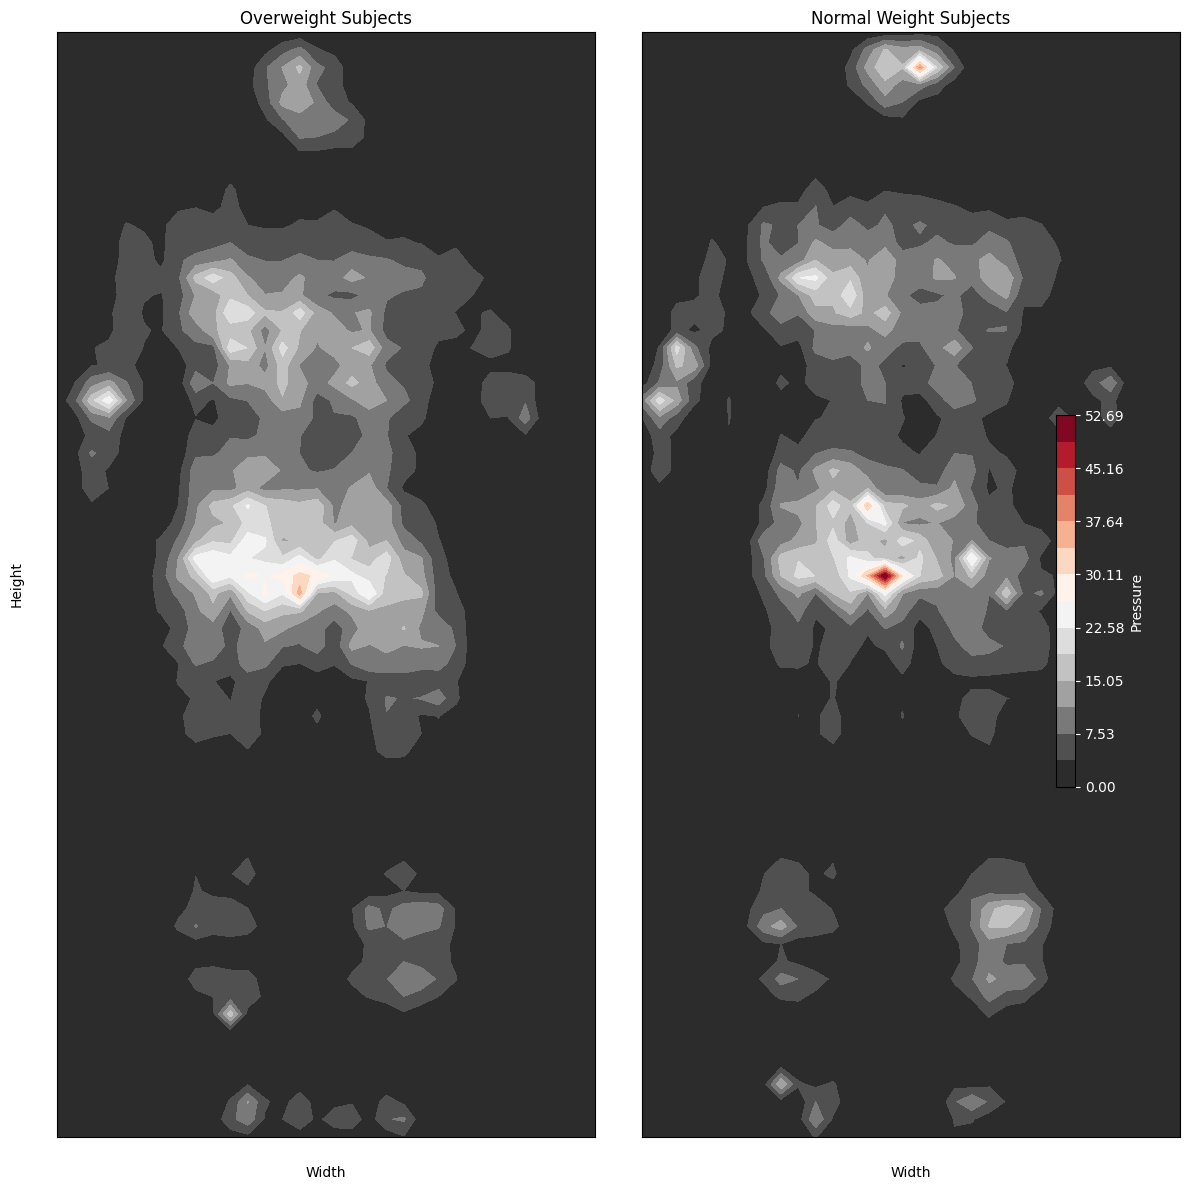

In [36]:
plot_pose_comparison_by_BMI(pose = "1")

C:\Users\lincc\AppData\Local\Temp\ipykernel_36516\2794045859.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


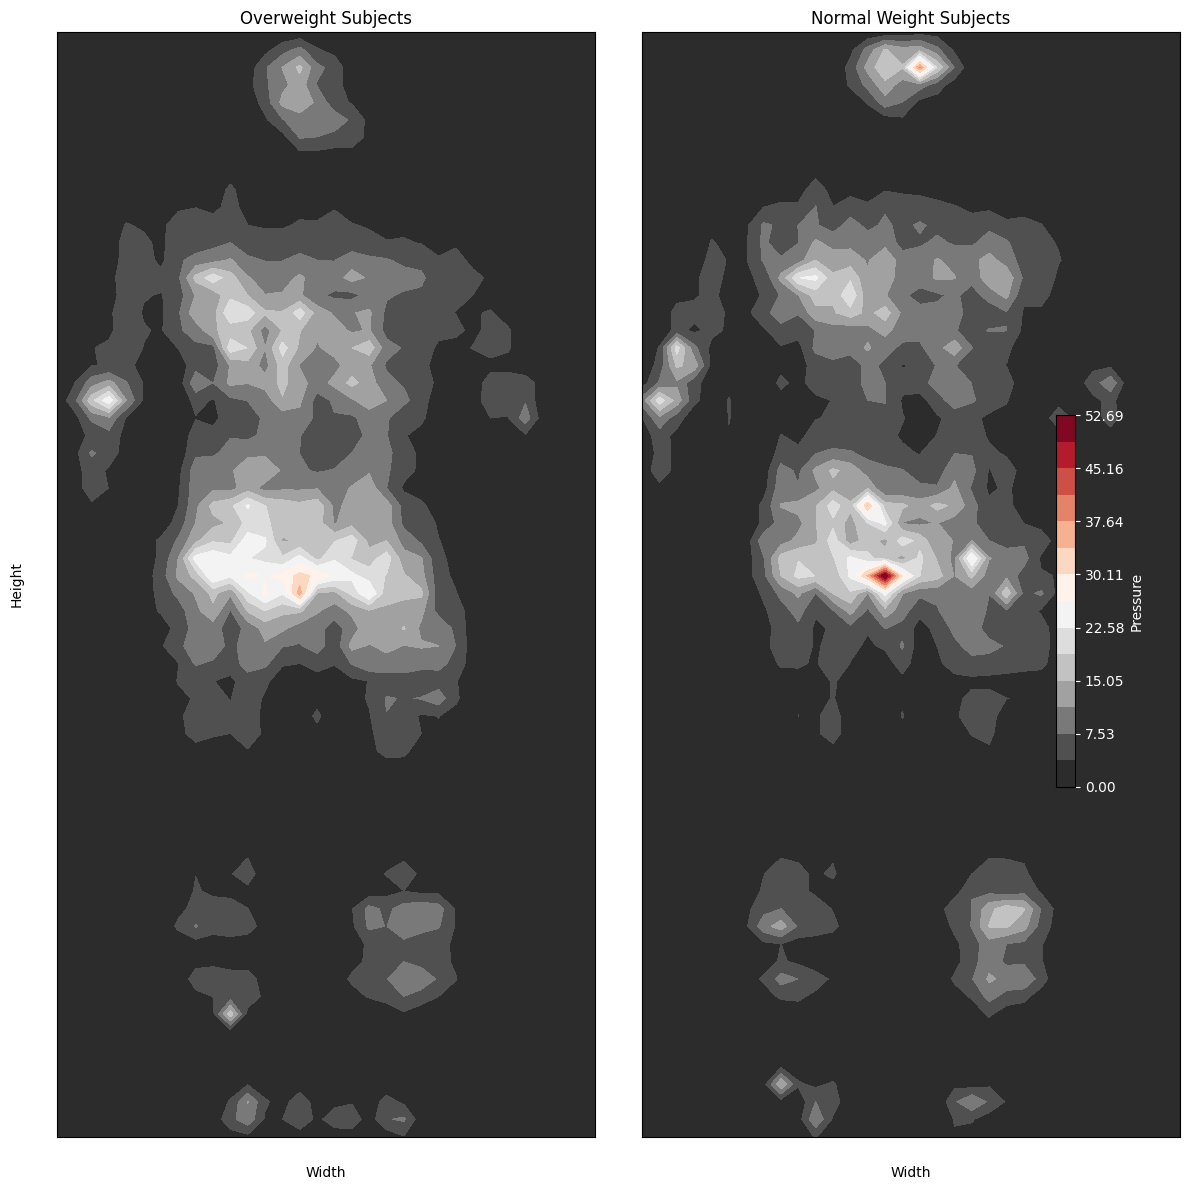

In [37]:
plot_pose_comparison_by_BMI(pose = "1")

In [38]:

def plot_pose_comparison_overweight(pose1_id, pose2_id, levels=15):
    """
    Plots a side-by-side contour map comparing the average pressure distribution 
    of two postures with identical contour levels.

    Parameters:
        pose1_id (str): Posture identifier for the first pose 
        pose2_id (str): Posture identifier for the second pose 
        levels (int): Number of contour levels (default is 15)
    """
    
    all_frames_pose1, all_frames_pose2 = [], []

    # Collect frames for Pose 1
    for subject, postures in subject_posture_data.items():
        if pose1_id in postures and subject in overweight_subject:
            all_frames_pose1.append(postures[pose1_id])  # Shape: (num_frames, 32, 64)

    # Collect frames for Pose 2
    for subject, postures in subject_posture_data.items():
        if pose2_id in postures and subject in overweight_subject:
            all_frames_pose2.append(postures[pose2_id])  # Shape: (num_frames, 32, 64)

    if all_frames_pose1 and all_frames_pose2:
        # Find minimum frame count across subjects for both postures
        min_frames_pose1 = min(f.shape[0] for f in all_frames_pose1)
        min_frames_pose2 = min(f.shape[0] for f in all_frames_pose2)

        # Trim all subject data to have the same frame count
        trimmed_pose1 = [f[:min_frames_pose1] for f in all_frames_pose1]
        trimmed_pose2 = [f[:min_frames_pose2] for f in all_frames_pose2]

        # Compute average pressure map for each posture
        avg_pose1 = np.mean(np.array(trimmed_pose1), axis=(0, 1))  # Mean over subjects and frames
        avg_pose2 = np.mean(np.array(trimmed_pose2), axis=(0, 1))  # Mean over subjects and frames

        # Find global min/max for consistent color scale
        vmin = min(avg_pose1.min(), avg_pose2.min())
        vmax = max(avg_pose1.max(), avg_pose2.max())

        # Generate identical contour levels
        contour_levels = np.linspace(vmin, vmax, levels)

        # Generate side-by-side contour plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 12))

        # Contour Plot for Pose 1
        X, Y = np.meshgrid(np.arange(avg_pose1.shape[1]), np.arange(avg_pose1.shape[0]))
        contour1 = axes[0].contourf(X, Y, avg_pose1, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        axes[0].set_title('Sleeping on the Back')
        axes[0].set_xlabel('Width')
        axes[0].set_ylabel('Height')
        axes[0].invert_yaxis()
        axes[0].tick_params(colors='white')

        # Contour Plot for Pose 2
        contour2 = axes[1].contourf(X, Y, avg_pose2, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        axes[1].set_title(f'Sleeping on the Left')
        axes[1].set_xlabel('Width')
        axes[1].invert_yaxis()
        axes[1].tick_params(colors='white')

        # Common colorbar for both plots with white font
        cbar = fig.colorbar(contour2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label('Pressure', color='white')
        cbar.ax.yaxis.set_tick_params(color='white')  # Change tick color
        plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')  # Change tick label color

        # Set white text for the entire figure
        
        plt.suptitle(f'Pressure Comparison: Posture {pose1_id} vs. Posture {pose2_id} (Same Contour Levels)', color='white')
        plt.tight_layout()
        plt.show()

    else:
        print(f"Not enough data found for Posture {pose1_id} or Posture {pose2_id}.")

C:\Users\lincc\AppData\Local\Temp\ipykernel_36516\3729560467.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


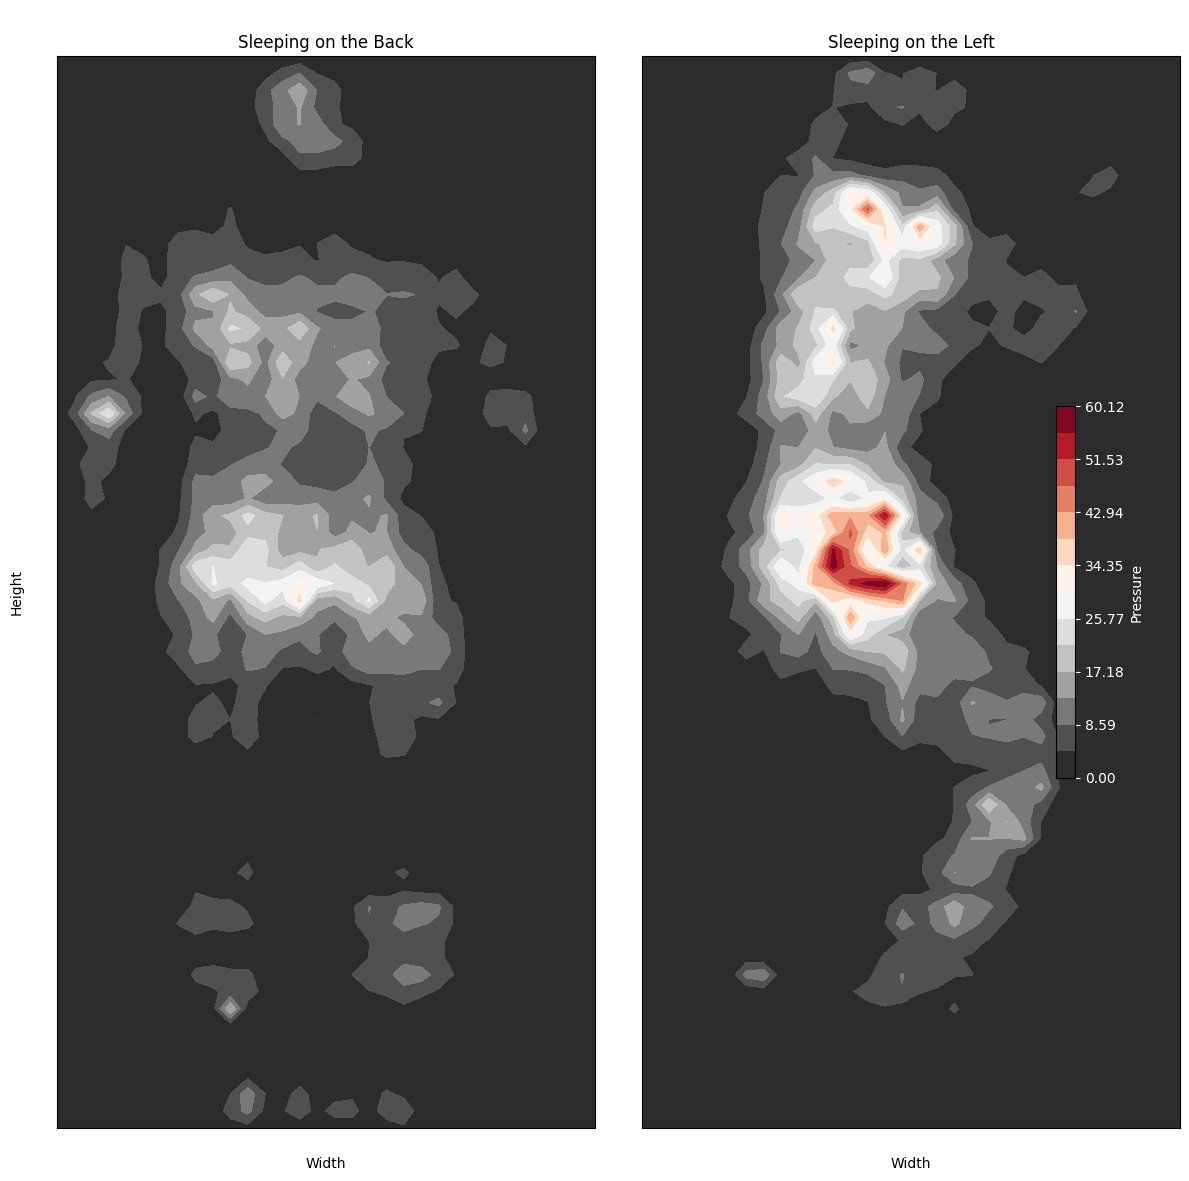

In [39]:
plot_pose_comparison_overweight(pose1_id="1", pose2_id="2")


In [40]:

def plot_pose_comparison_normal(pose1_id, pose2_id, levels=15):
    """
    Plots a side-by-side contour map comparing the average pressure distribution 
    of two postures with identical contour levels.

    Parameters:
        pose1_id (str): Posture identifier for the first pose 
        pose2_id (str): Posture identifier for the second pose 
        levels (int): Number of contour levels (default is 15)
    """
    
    all_frames_pose1, all_frames_pose2 = [], []

    # Collect frames for Pose 1
    for subject, postures in subject_posture_data.items():
        if pose1_id in postures and subject in normal_kg_subject:
            all_frames_pose1.append(postures[pose1_id])  # Shape: (num_frames, 32, 64)

    # Collect frames for Pose 2
    for subject, postures in subject_posture_data.items():
        if pose2_id in postures and subject in normal_kg_subject:
            all_frames_pose2.append(postures[pose2_id])  # Shape: (num_frames, 32, 64)

    if all_frames_pose1 and all_frames_pose2:
        # Find minimum frame count across subjects for both postures
        min_frames_pose1 = min(f.shape[0] for f in all_frames_pose1)
        min_frames_pose2 = min(f.shape[0] for f in all_frames_pose2)

        # Trim all subject data to have the same frame count
        trimmed_pose1 = [f[:min_frames_pose1] for f in all_frames_pose1]
        trimmed_pose2 = [f[:min_frames_pose2] for f in all_frames_pose2]

        # Compute average pressure map for each posture
        avg_pose1 = np.mean(np.array(trimmed_pose1), axis=(0, 1))  # Mean over subjects and frames
        avg_pose2 = np.mean(np.array(trimmed_pose2), axis=(0, 1))  # Mean over subjects and frames

        # Find global min/max for consistent color scale
        vmin = min(avg_pose1.min(), avg_pose2.min())
        vmax = max(avg_pose1.max(), avg_pose2.max())

        # Generate identical contour levels
        contour_levels = np.linspace(vmin, vmax, levels)

        # Generate side-by-side contour plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 12))

        # Contour Plot for Pose 1
        X, Y = np.meshgrid(np.arange(avg_pose1.shape[1]), np.arange(avg_pose1.shape[0]))
        contour1 = axes[0].contourf(X, Y, avg_pose1, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        axes[0].set_title('Sleeping on the Back')
        axes[0].set_xlabel('Width')
        axes[0].set_ylabel('Height')
        axes[0].invert_yaxis()
        axes[0].tick_params(colors='white')

        # Contour Plot for Pose 2
        contour2 = axes[1].contourf(X, Y, avg_pose2, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        axes[1].set_title(f'Sleeping on the Left')
        axes[1].set_xlabel('Width')
        axes[1].invert_yaxis()
        axes[1].tick_params(colors='white')

        # Common colorbar for both plots with white font
        cbar = fig.colorbar(contour2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label('Pressure', color='white')
        cbar.ax.yaxis.set_tick_params(color='white')  # Change tick color
        plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')  # Change tick label color

        # Set white text for the entire figure
        
        plt.suptitle(f'Pressure Comparison: Posture {pose1_id} vs. Posture {pose2_id} (Same Contour Levels)', color='white')
        plt.tight_layout()
        plt.show()

    else:
        print(f"Not enough data found for Posture {pose1_id} or Posture {pose2_id}.")

C:\Users\lincc\AppData\Local\Temp\ipykernel_36516\3705796783.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


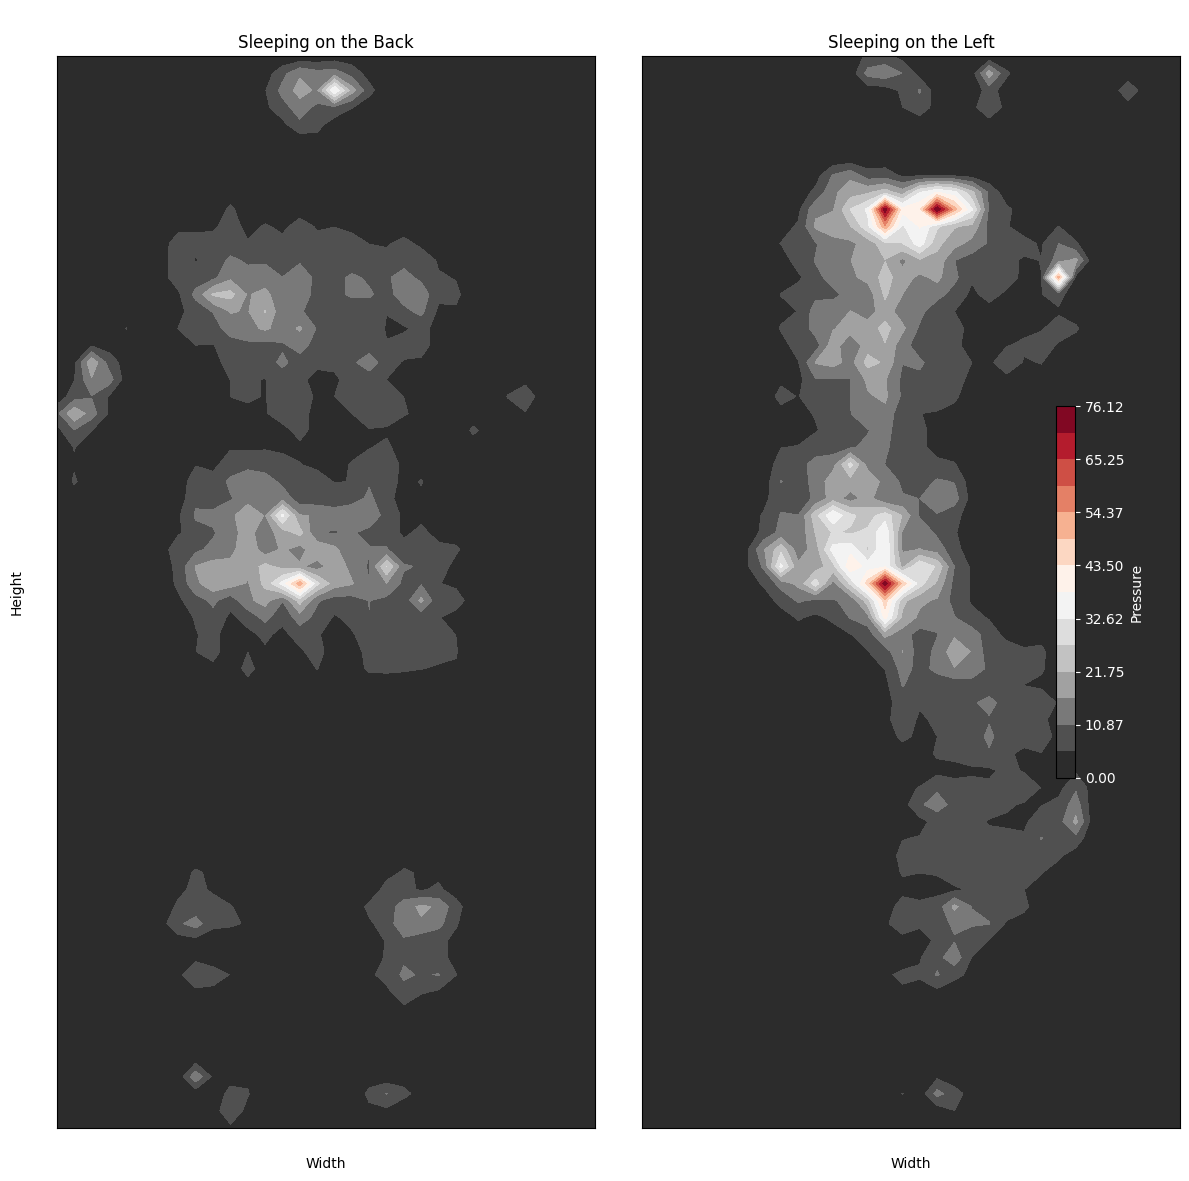

In [41]:
plot_pose_comparison_normal(pose1_id="1", pose2_id="2")


In [42]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pressure_difference_comparison(pose1_id="1", pose2_id="2", levels=15):
    """
    Computes and compares the pressure difference (last 10 - first 10 frames) 
    for two postures using side-by-side contour maps.

    Parameters:
        pose1_id (str): Posture identifier for the first pose (default: '1')
        pose2_id (str): Posture identifier for the second pose (default: '2')
        levels (int): Number of contour levels (default is 10)
    """
    all_frames_pose1, all_frames_pose2 = [], []

    # Collect frames for Posture 1
    for subject, postures in subject_posture_data.items():
        if pose1_id in postures and subject in overweight_subject:
            all_frames_pose1.append(postures[pose1_id])  # Shape: (num_frames, 32, 64)

    # Collect frames for Posture 2
    for subject, postures in subject_posture_data.items():
        if pose2_id in postures and subject in overweight_subject:
            all_frames_pose2.append(postures[pose2_id])  # Shape: (num_frames, 32, 64)

    if all_frames_pose1 and all_frames_pose2:
        # Find minimum frame count across subjects for both postures
        min_frames_pose1 = min(f.shape[0] for f in all_frames_pose1)
        min_frames_pose2 = min(f.shape[0] for f in all_frames_pose2)

     

        # Trim all subject data to have the same frame count
        trimmed_pose1 = [f[:min_frames_pose1] for f in all_frames_pose1]
        trimmed_pose2 = [f[:min_frames_pose2] for f in all_frames_pose2]

        # Compute average pressure per frame for each posture
        avg_pose1 = np.mean(np.array(trimmed_pose1), axis=0)  # Mean over subjects
        avg_pose2 = np.mean(np.array(trimmed_pose2), axis=0)  # Mean over subjects

        # Debugging: Print shapes
        print(f"Shape of avg_pose1: {avg_pose1.shape}, avg_pose2: {avg_pose2.shape}")

        # Ensure we slice along the correct axis (frames)
        if avg_pose1.shape[0] < 10 or avg_pose2.shape[0] < 10:
            print(f"Error: Not enough frames after averaging. Found {avg_pose1.shape[0]} frames.")
            return

        # Compute first and last 10-frame averages
        first_10_avg_pose1 = np.mean(avg_pose1[:20], axis=0)  # Shape: (32, 64)
        last_10_avg_pose1 = np.mean(avg_pose1[20:], axis=0)  # Shape: (32, 64)

        first_10_avg_pose2 = np.mean(avg_pose2[:20], axis=0)  # Shape: (32, 64)
        last_10_avg_pose2 = np.mean(avg_pose2[20:], axis=0)  # Shape: (32, 64)

        # Debugging: Print shapes
        print(f"Shape of first_10_avg_pose1: {first_10_avg_pose1.shape}, last_10_avg_pose1: {last_10_avg_pose1.shape}")
        print(f"Shape of first_10_avg_pose2: {first_10_avg_pose2.shape}, last_10_avg_pose2: {last_10_avg_pose2.shape}")

        # Compute the difference (last 10 - first 10) for each posture
        pressure_diff_pose1 = last_10_avg_pose1 - first_10_avg_pose1
        pressure_diff_pose2 = last_10_avg_pose2 - first_10_avg_pose2

        # Find global min/max for consistent color scale
        vmin = min(pressure_diff_pose1.min(), pressure_diff_pose2.min())
        vmax = max(pressure_diff_pose1.max(), pressure_diff_pose2.max())

        # Generate identical contour levels
        contour_levels = np.linspace(vmin, vmax, levels)

        # Generate side-by-side contour plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 12))

        # Contour Plot for Posture 1
        X, Y = np.meshgrid(np.arange(pressure_diff_pose1.shape[1]), np.arange(pressure_diff_pose1.shape[0]))
        contour1 = axes[0].contourf(X, Y, pressure_diff_pose1, levels=contour_levels, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axes[0].set_title(f'Sleeping on the back')
        axes[0].set_xlabel('Width')
        axes[0].set_ylabel('Height')
        axes[0].invert_yaxis()

        # Contour Plot for Posture 2
        contour2 = axes[1].contourf(X, Y, pressure_diff_pose2, levels=contour_levels, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axes[1].set_title(f'Sleeping on the left')
        axes[1].set_xlabel('Width')
        axes[1].invert_yaxis()

        # Common colorbar for both plots
        cbar = fig.colorbar(contour2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label('Pressure Change Over 20 Sec (mmHg)')

        plt.tight_layout()
        plt.show()

    else:
        print(f"Not enough data found for Posture {pose1_id} or Posture {pose2_id}.")


Shape of avg_pose1: (77, 64, 32), avg_pose2: (65, 64, 32)
Shape of first_10_avg_pose1: (64, 32), last_10_avg_pose1: (64, 32)
Shape of first_10_avg_pose2: (64, 32), last_10_avg_pose2: (64, 32)


C:\Users\lincc\AppData\Local\Temp\ipykernel_36516\806363226.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


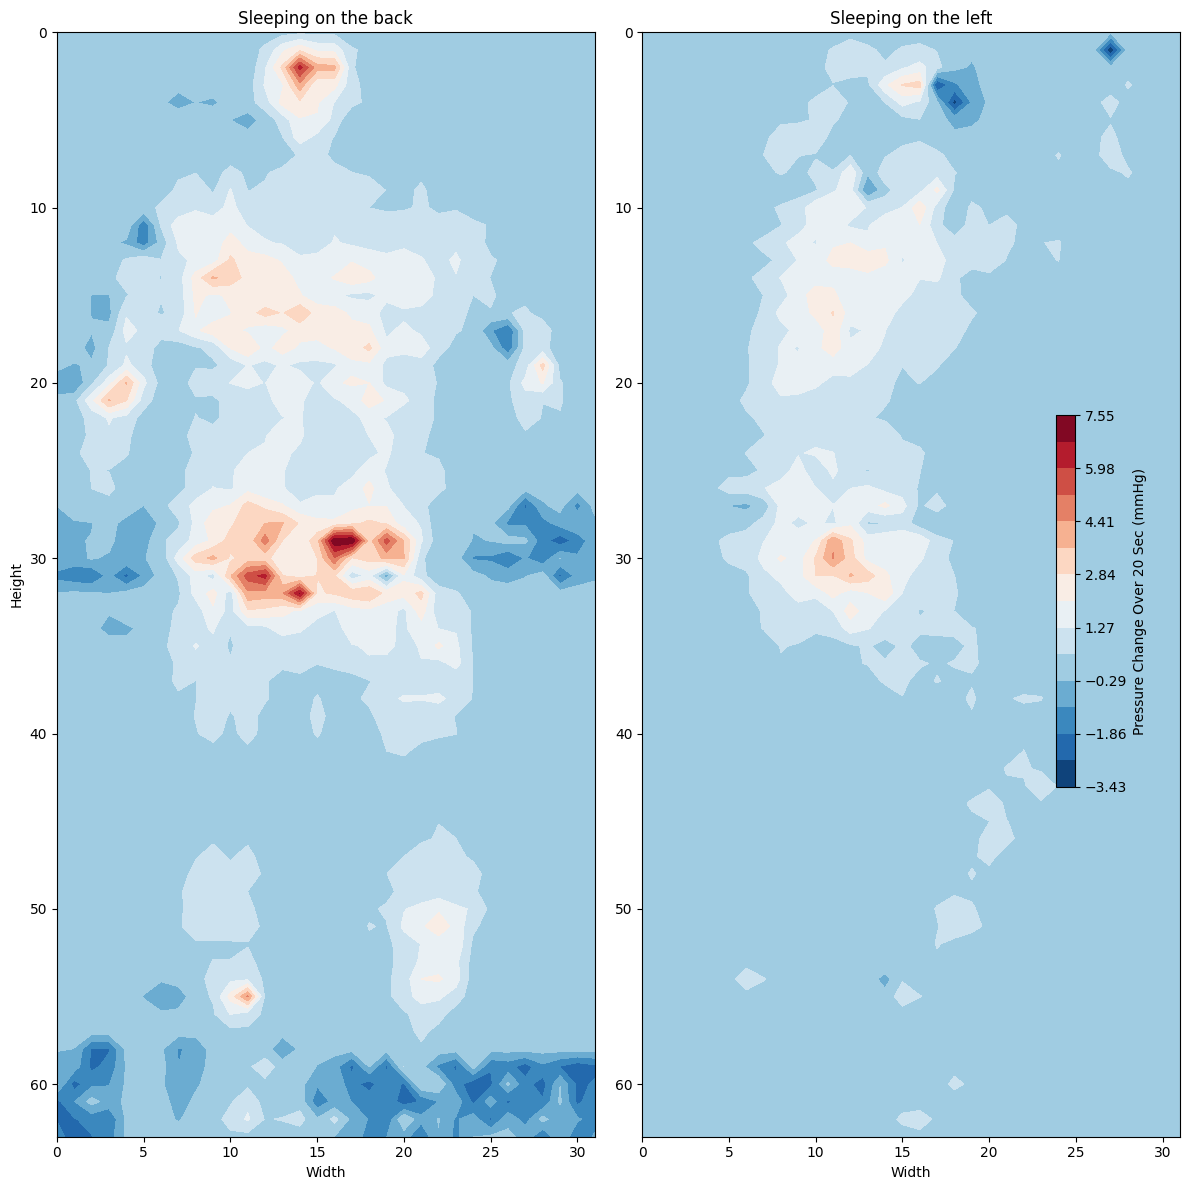

In [43]:
plot_pressure_difference_comparison(pose1_id="1", pose2_id="2")


In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pose_comparison_all(pose1_id, pose2_id, levels=15):
    """
    Plots a 2x2 contour map comparing the average pressure distribution 
    of two postures for normal-weight and overweight subjects.

    Parameters:
        pose1_id (str): Posture identifier for the first pose.
        pose2_id (str): Posture identifier for the second pose.
        levels (int): Number of contour levels (default is 15).
    """
    
    def compute_average_pressure(pose_id, subject_group):
        """ Helper function to compute average pressure distribution for a given pose and subject group. """
        all_frames = [
            postures[pose_id] for subject, postures in subject_posture_data.items()
            if pose_id in postures and subject in subject_group
        ]
        
        if not all_frames:
            return None  # Not enough data
        
        min_frames = min(f.shape[0] for f in all_frames)
        trimmed_data = [f[:min_frames] for f in all_frames]
        return np.mean(np.array(trimmed_data), axis=(0, 1))  # Mean over subjects and frames

    # Compute average pressure maps
    avg_normal_pose1 = compute_average_pressure(pose1_id, normal_kg_subject)
    avg_normal_pose2 = compute_average_pressure(pose2_id, normal_kg_subject)
    avg_overweight_pose1 = compute_average_pressure(pose1_id, overweight_subject)
    avg_overweight_pose2 = compute_average_pressure(pose2_id, overweight_subject)

    # Determine global min/max pressure values for consistent contour levels
    vmin = min(avg_normal_pose1.min(), avg_normal_pose2.min(), avg_overweight_pose1.min(), avg_overweight_pose2.min())
    vmax = max(avg_normal_pose1.max(), avg_normal_pose2.max(), avg_overweight_pose1.max(), avg_overweight_pose2.max())
    contour_levels = np.linspace(vmin, vmax, levels)

    # Set up figure and axes (2x2 layout)
    fig, axes = plt.subplots(2, 2, figsize=(14, 28))
    
    # Meshgrid for contour plots
    X, Y = np.meshgrid(np.arange(avg_normal_pose1.shape[1]), np.arange(avg_normal_pose1.shape[0]))

    # Plot each contour
    plots = [
        (avg_normal_pose1, axes[0, 0], f'Normal Weight: Pose {pose1_id}'),
        (avg_normal_pose2, axes[0, 1], f'Normal Weight: Pose {pose2_id}'),
        (avg_overweight_pose1, axes[1, 0], f'Overweight: Pose {pose1_id}'),
        (avg_overweight_pose2, axes[1, 1], f'Overweight: Pose {pose2_id}')
    ]
    
    contours = []
    for avg_pressure, ax, title in plots:
        contour = ax.contourf(X, Y, avg_pressure, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        contours.append(contour)
        ax.set_title(title, fontsize=14, color='white')
        ax.set_xlabel('Width', fontsize=12, color='white')
        ax.set_ylabel('Height', fontsize=12, color='white')
        ax.invert_yaxis()
        ax.tick_params(colors='white')

    # Set white title for the figure
    plt.suptitle(f'Pressure Comparison: Normal vs. Overweight for Pose {pose1_id} and Pose {pose2_id}', color='white', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Create separate figure for colorbar
    fig_cbar = plt.figure(figsize=(2, 6))  # Adjust size as needed
    cbar_ax = fig_cbar.add_axes([0.1, 0.1, 0.3, 0.8])  # Position of colorbar
    cbar = fig_cbar.colorbar(contours[0], cax=cbar_ax)  # Use one of the contour plots for colorbar
    cbar.set_label('Pressure (mmHg)', color='black')  # Set label color
    cbar.ax.yaxis.set_tick_params(color='black')
    plt.setp(cbar.ax.yaxis.get_ticklabels(), color='black')  # Set tick label color
    plt.show()  # Show separate colorbar



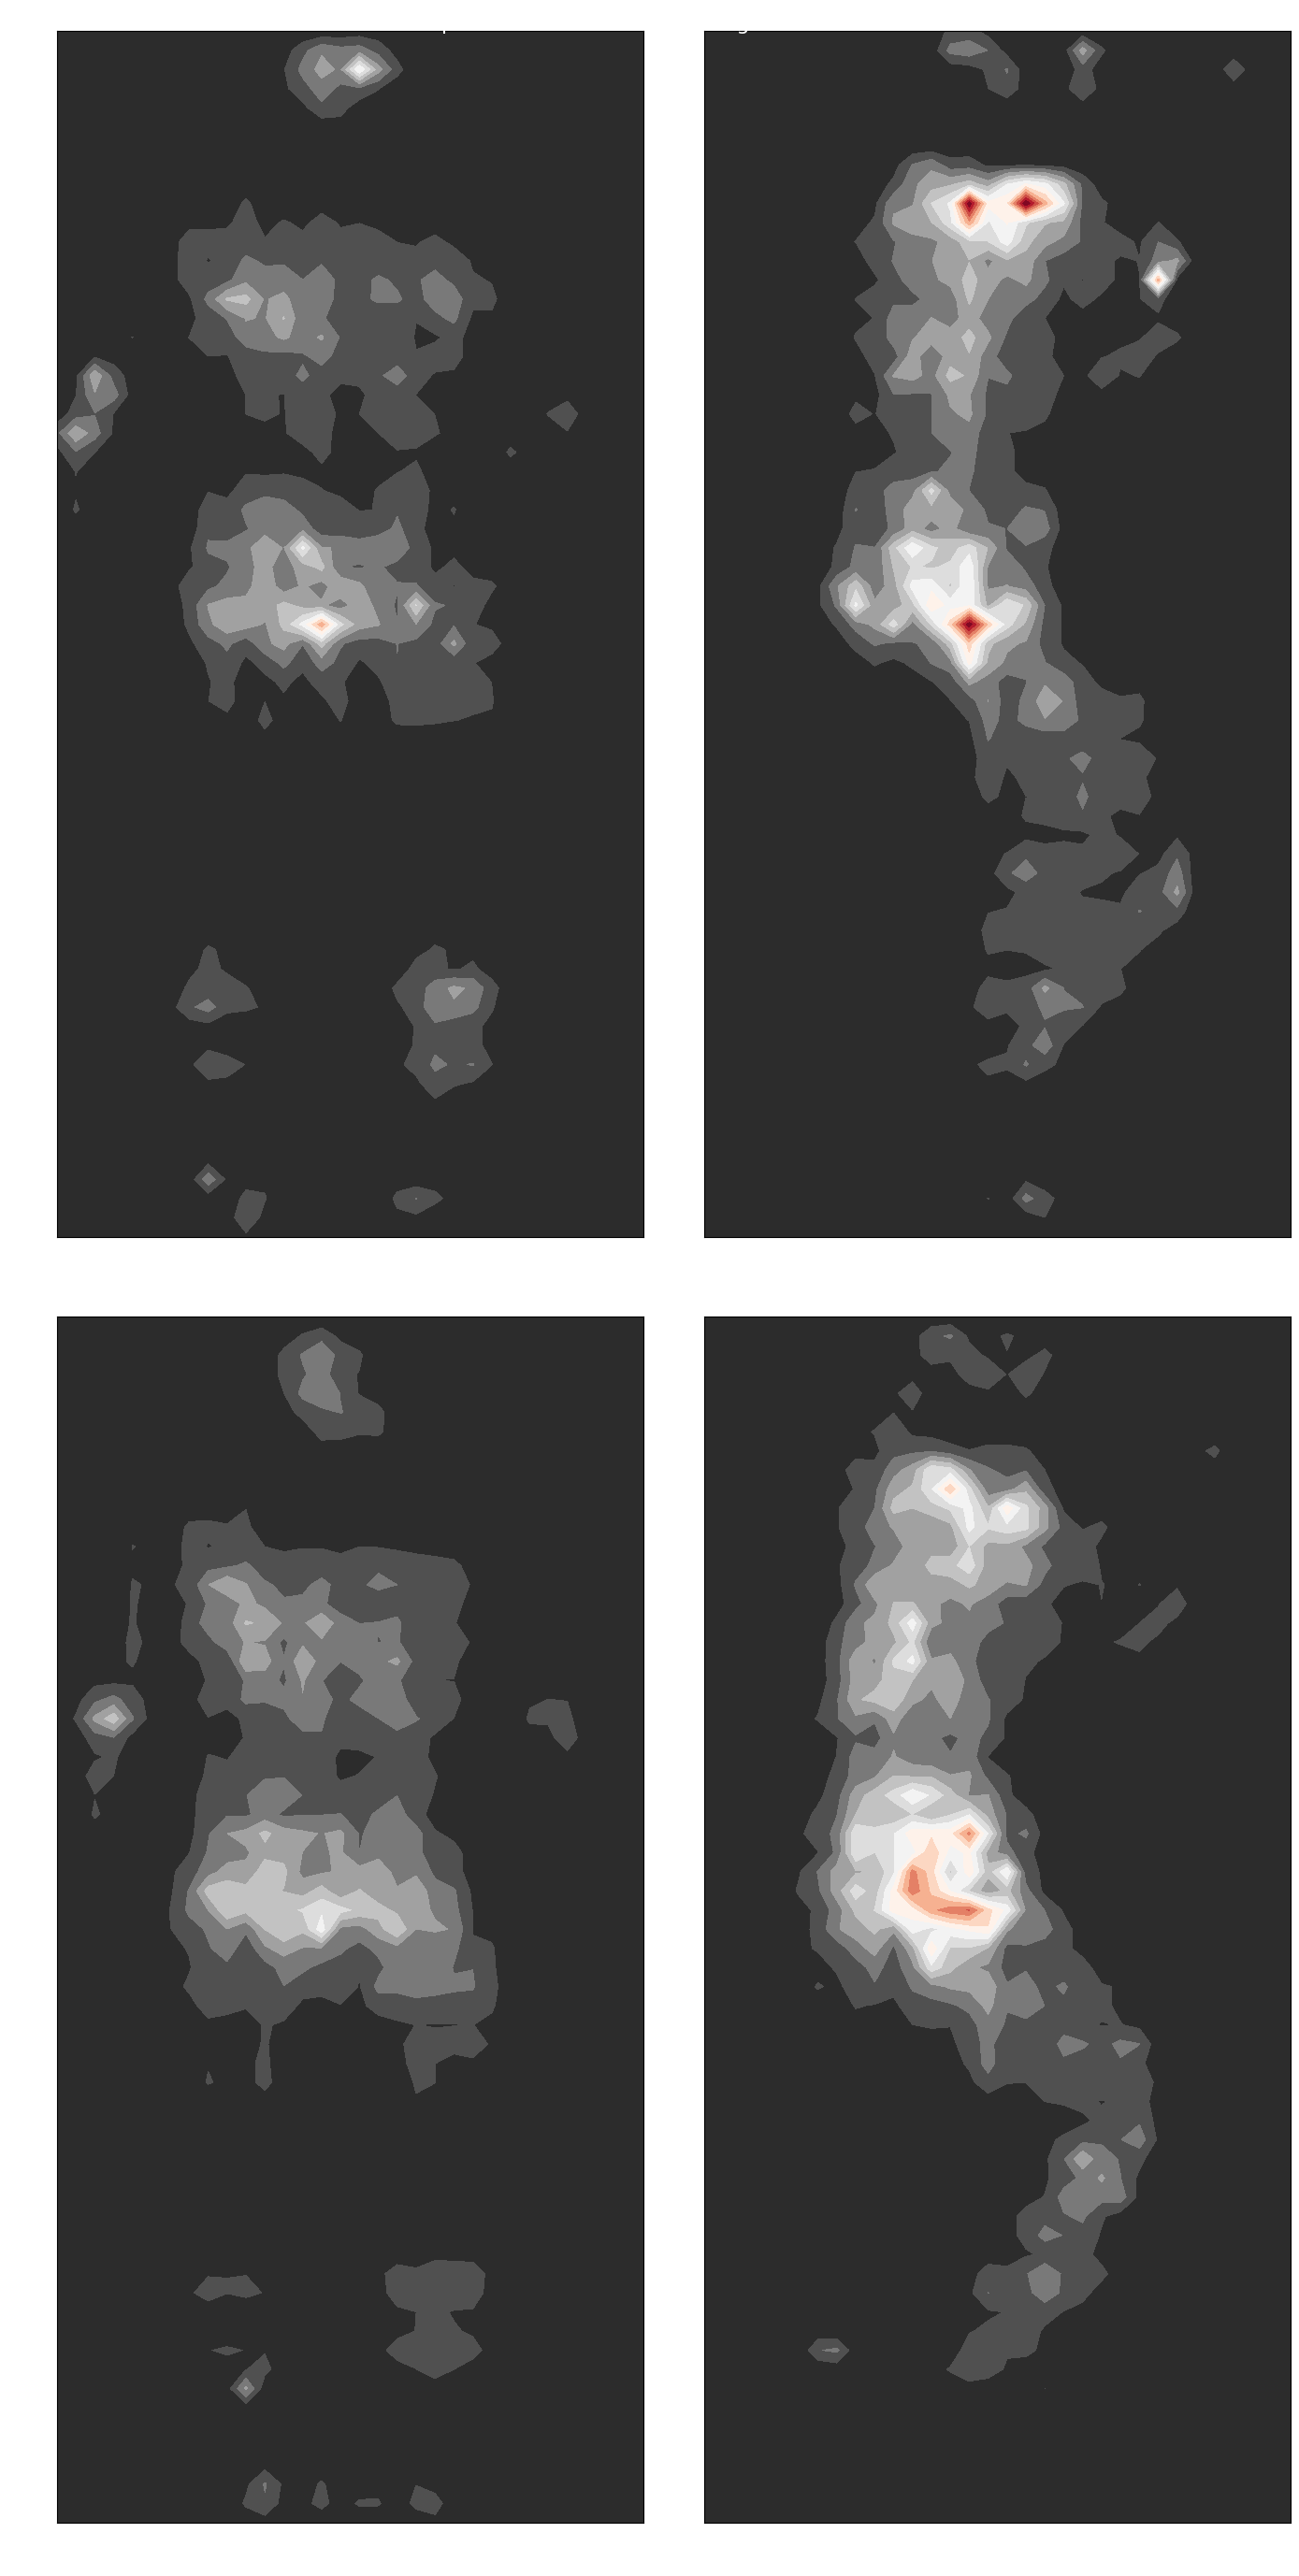

C:\Users\lincc\AppData\Local\Temp\ipykernel_36516\2498089868.py:72: UserWarning: Adding colorbar to a different Figure <Figure size 1400x2800 with 4 Axes> than <Figure size 200x600 with 1 Axes> which fig.colorbar is called on.
  cbar = fig_cbar.colorbar(contours[0], cax=cbar_ax)  # Use one of the contour plots for colorbar


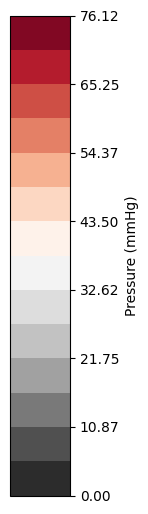

In [45]:
plot_pose_comparison_all(pose1_id="1", pose2_id="2", levels=15)


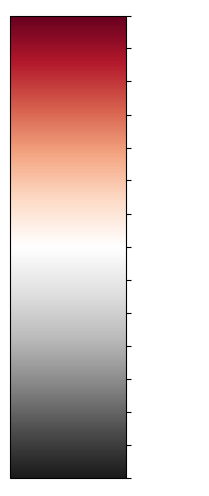

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_only_colorbar(vmin, vmax, levels=15, cmap='RdGy_r'):
    """
    Plots only the colorbar without any contour plot.
    
    Parameters:
        vmin (float): Minimum pressure value.
        vmax (float): Maximum pressure value.
        levels (int): Number of contour levels.
        cmap (str): Colormap for the colorbar.
    """
    
    fig, ax = plt.subplots(figsize=(1.5, 6))  # Adjust figure size for a vertical colorbar
    
    # Create a dummy scalar mappable for the colorbar
    norm = plt.Normalize(vmin, vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # No data needed

    # Add the colorbar
    cbar = fig.colorbar(sm, cax=ax, orientation='vertical', ticks=np.linspace(vmin, vmax, levels))
    cbar.set_label('Pressure', color='white', fontsize=12)
    
    # Customize tick labels
    cbar.ax.yaxis.set_tick_params(color='black')
    plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')

    plt.show()

# Example Usage: Set vmin and vmax based on your data range
plot_only_colorbar(vmin=0, vmax=100)
